<a href="https://colab.research.google.com/github/ykato27/Time-Series-Deep-Learning/blob/main/LSTM_pytorch_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple LSTM model in PyTorch for predicting noisy sine wave data 


In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np


In [2]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0)
        output = self.output_layer(output[:, -1, :])

        return output


In [3]:
def mkDataSet(data_size, data_length=50, freq=60., noise=0.01):
    """
    params\n
    data_size : データセットサイズ\n
    data_length : 各データの時系列長\n
    freq : 周波数\n
    noise : ノイズの振幅\n
    returns\n
    train_x : トレーニングデータ（t=1,2,...,size-1の値)\n
    train_t : トレーニングデータのラベル（t=sizeの値）\n
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq) + np.random.normal(loc=0.0, scale=noise)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return train_x, train_t


In [4]:
def mkRandomBatch(train_x, train_t, batch_size=10):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for i in range(batch_size):
#        idx = np.random.randint(0, len(train_x) - 1)
        idx= i
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x), torch.tensor(batch_t)


In [5]:
training_size = 10000
test_size = 1000
epochs_num = 300
hidden_size = 5
batch_size = 100

train_x, train_t = mkDataSet(training_size)
test_x, test_t = mkDataSet(test_size)

model = Predictor(1, hidden_size, 1)
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.01)

for epoch in range(epochs_num):
        # training
        running_loss = 0.0
        training_accuracy = 0.0
        for i in range(int(training_size / batch_size)):
            optimizer.zero_grad()


            data, label = mkRandomBatch(train_x, train_t, batch_size)

            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            training_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)

        #test
        test_accuracy = 0.0
        for i in range(int(test_size / batch_size)):
            offset = i * batch_size
            data, label = torch.tensor(test_x[offset:offset+batch_size]), torch.tensor(test_t[offset:offset+batch_size])
            output = model(data, None)

            test_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)
        
        training_accuracy /= training_size
        test_accuracy /= test_size

        print('%d loss: %.3f, training_accuracy: %.5f, test_accuracy: %.5f' % (
            epoch + 1, running_loss, training_accuracy, test_accuracy))




1 loss: 50.028, training_accuracy: 0.06570, test_accuracy: 0.06800
2 loss: 32.689, training_accuracy: 0.10000, test_accuracy: 0.09100
3 loss: 21.386, training_accuracy: 0.11200, test_accuracy: 0.12000
4 loss: 11.634, training_accuracy: 0.14830, test_accuracy: 0.13100
5 loss: 6.205, training_accuracy: 0.14770, test_accuracy: 0.11900
6 loss: 4.258, training_accuracy: 0.15200, test_accuracy: 0.13600
7 loss: 3.643, training_accuracy: 0.16630, test_accuracy: 0.13500
8 loss: 3.363, training_accuracy: 0.17450, test_accuracy: 0.16500
9 loss: 3.166, training_accuracy: 0.21340, test_accuracy: 0.19900
10 loss: 3.000, training_accuracy: 0.25480, test_accuracy: 0.23000
11 loss: 2.854, training_accuracy: 0.26650, test_accuracy: 0.23400
12 loss: 2.723, training_accuracy: 0.28000, test_accuracy: 0.23800
13 loss: 2.605, training_accuracy: 0.28000, test_accuracy: 0.24200
14 loss: 2.497, training_accuracy: 0.28840, test_accuracy: 0.24300
15 loss: 2.398, training_accuracy: 0.29800, test_accuracy: 0.25700


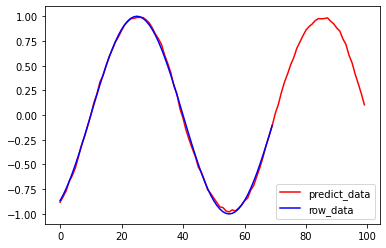

In [6]:
import matplotlib.pyplot as plt

data, label = mkRandomBatch(test_x, test_t, batch_size)
output=model(data)

plt.figure()
plt.plot(output.data, color="r", label="predict_data")
plt.plot(label.data[:70], color="b", label="row_data")
plt.legend()
plt.show()
